In [2]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import transformers
import torch
import numpy as np

In [4]:
!pip install datasets

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from datasets import load_dataset
emotions = load_dataset("emotion", trust_remote_code=True)
labels=emotions['train'].features['label']
id2label={k:v for k,v in enumerate(labels.names)}
id2label

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [27]:
from transformers import AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained("distilbert-base-cased")

def tokenize(batch):
 return tokenizer(batch["text"], padding=True, truncation=True)

emotions_encoded= emotions.map(tokenize,batched=True, batch_size=None)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [9]:
# Load the model
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device) # AutoModel.from_pretrained class loads the weights of pretrained models

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Extracting Last Hidden state

The "last hidden state" in the context of transformer models like BERT refers to the final layer's hidden representations for each token in the input sequence after the model has processed it. Here's a detailed explanation:

### Understanding Hidden States

#### Hidden States in Transformer Models:

- Transformer models consist of multiple layers of self-attention and feed-forward neural networks.
- Each layer produces a hidden state for every token in the input sequence. These hidden states are vectors that capture various aspects of the token's context within the sequence.

#### Layer Structure:

- A typical transformer model, such as BERT, has several layers (e.g., 12 layers for BERT-base, 24 layers for BERT-large).
- Each layer processes the hidden states from the previous layer and outputs a new set of hidden states.

### Last Hidden State

#### Final Layer Output:
- The last hidden state refers to the hidden representations produced by the final layer of the model.

#### Token Representation:
- For each token in the input sequence, there is a corresponding hidden state in the last layer. These hidden states are vectors of a fixed size (e.g., 768 dimensions for BERT-base).

#### Contextual Information:
- These hidden states capture rich contextual information about the tokens, informed by all the preceding layers' computations and the entire input sequence.

### Practical Use of Last Hidden State

The last hidden state is often used for various downstream tasks because it contains the most refined and contextually aware representations of the input tokens. For example:

#### Classification:

- **[CLS] Token**: For classification tasks, the hidden state corresponding to the special [CLS] token is used. This token is added to the beginning of the input sequence, and its hidden state in the last layer is designed to capture the overall meaning of the sequence.
- **Usage**: This [CLS] hidden state is fed into a classification layer (usually a simple feed-forward neural network) to perform the classification.

#### Token-Level Tasks:

- **NER, POS Tagging**: For tasks like Named Entity Recognition (NER) or Part-of-Speech (POS) tagging, the hidden states of all tokens in the last layer are used to make predictions for each token.

### Shape of Last Hidden State

#### Shape Explanation:
- The shape of `last_hidden_state` will be (batch_size, sequence_length, hidden_size).
  - **batch_size**: Number of input sequences processed together (useful for batch processing).
  - **sequence_length**: Number of tokens in the input sequence (including special tokens like [CLS] and [SEP]).
  - **hidden_size**: Dimensionality of the hidden state vectors (e.g., 768 for BERT-base).


The last hidden state in transformer models like BERT is a crucial component that provides the final, contextually rich representations of the input tokens. These representations are used for various downstream tasks, making them an essential part of how these models achieve high performance on a wide range of NLP tasks.


In [10]:
# Example
text= "this is a test"
inputs = tokenizer(text,return_tensors='pt')
#place inputs dictionary to the same deveice
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs=model(inputs["input_ids"], inputs["attention_mask"])
last_hid_state=outputs.last_hidden_state

In [11]:
""" For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token
appears at the start of each sequence, we can extract it by simply indexing into
outputs.last_hidden_state"""
# hidden state corresponding to all input tokens/input sequence.
# token arragement is like: [CLS] sequence1_tokens [SEP] sequence2_tokens [SEP] ......
last_hid_state.shape

torch.Size([1, 6, 768])

In [ ]:
# hidden state corresponding to [CLS] token
cls_hid_state=last_hid_state[:,0,:]
cls_hid_state.shape

torch.Size([1, 768])

For the whole dataset by create a new hidden_state column that stores all these vectors.

In [ ]:
def extract_CLS_hidden_states(batch):
    # Place the model inputs on GPU

    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names }
    # Extracting the last hidden state
    with torch.no_grad():
        outputs=model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    # return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0,:].cpu().numpy()}

In [ ]:
# extracting [CLS] hidden states of our emotions dataset
emotions_encoded.set_format("torch",columns=["input_ids","attention_mask","label"])
emotions_CLS_hidden_state = emotions_encoded.map(extract_CLS_hidden_states, batched=True, batch_size=8,)
emotions_CLS_hidden_state

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [ ]:
# emotions_CLS_hidden_state.save_to_disk(os.path.join(r"/content/drive/MyDrive/model_params","emotions_CLS_hidden_state.pt"))

Saving the dataset (0/1 shards):   0%|          | 0/16000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

## Creating a Feature Matrix

In [ ]:
from datasets import load_from_disk
emotions_CLS_hidden_state = load_from_disk(r'data/emotions_CLS_hidden_state')

In [ ]:
# Hidden states as input features
# Labels as targets
X_train = emotions_CLS_hidden_state["train"]["hidden_state"]
y_train = emotions_CLS_hidden_state["train"]["label"]

X_valid = emotions_CLS_hidden_state["validation"]["hidden_state"]
y_valid = emotions_CLS_hidden_state["validation"]["label"]

X_test = emotions_CLS_hidden_state["test"]["hidden_state"]
y_test = emotions_CLS_hidden_state["test"]["label"]

### Training a simple classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [ ]:
lr_clf.score(X_valid, y_valid)

0.4365

In [ ]:
# classification report
from sklearn.metrics import classification_report

y_pred=lr_clf.predict(X_valid)
pd.set_option('display.precision', 2)
clf_report=pd.DataFrame(classification_report(y_valid, y_pred,output_dict=True,labels=list(id2label.keys()),target_names=list(id2label.values())),).T
clf_report

,precision,recall,f1-score,support
sadness,0.40,0.53,0.45,550.00
joy,0.47,0.65,0.55,704.00
love,0.33,0.07,0.12,178.00
anger,0.46,0.23,0.30,275.00
fear,0.42,0.20,0.27,212.00
surprise,0.50,0.02,0.05,81.00
accuracy,0.44,0.44,0.44,0.44
macro avg,0.43,0.29,0.29,2000.00
weighted avg,0.43,0.44,0.40,2000.00


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(y_true, y_predictions, labels, normalize=None ):
    cm = confusion_matrix(y_valid, y_pred,labels=labels,normalize=normalize)

    fig, ax = plt.subplots(figsize=(6,6))
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id2label.values()))
    cm_disp.plot(cmap='Blues',colorbar=False,values_format='.2f',ax=ax)
    plt.title("Confusion Matrix")
    plt.show()

# plot_confusion_matrix(y_valid, y_pred, labels=list(id2label.keys()))

## Fine-Tuning Transformers


#### Use `AutoModelForSequenceClassification` instead of `AutoModel`

The main difference between `transformers.AutoModel.from_pretrained` and `AutoModelForSequenceClassification` lies in the type of model they load and their intended use cases.

### `transformers.AutoModel.from_pretrained(...)`

- **General Purpose**: `AutoModel.from_pretrained` loads a general-purpose transformer model from the Hugging Face model hub. This is a base model without any specific task head attached to it.
- **Usage**: It is used when you want to perform tasks that do not require a specific task head, or if you plan to add your custom head for tasks like token classification, feature extraction, or fine-tuning for a custom task.

### `transformers.AutoModelForSequenceClassification.from_pretrained(...)`

- **Task-Specific**: `AutoModelForSequenceClassification.from_pretrained` loads a pre-trained transformer model specifically tailored for sequence classification tasks. This model comes with an additional classification head on top of the base model, which is designed for tasks like sentiment analysis, text classification, or any other task that involves classifying sequences of text.
- **Usage**: It is used when you need a model ready for sequence classification tasks. This head typically consists of a linear layer on top of the base model, followed by a softmax activation for classification.

### Key Differences

**Model Structure**:
- `AutoModel`: Provides the base model without any task-specific heads.
- `AutoModelForSequenceClassification`: Includes a classification head on top of the base model.

**Use Case**:
- `AutoModel`: Suitable for general tasks or when you want to customize the task head.
- `AutoModelForSequenceClassification`: Directly used for sequence classification tasks.

**Outputs**:
- `AutoModel`: Outputs the hidden states of the base model.
- `AutoModelForSequenceClassification`: Outputs the logits or classification scores from the classification head.


We just need to specify how many labels the model has to predict (six in our case), since this
dictates the number of outputs the classification head has

### Defining metrics to evaluate model performance during fine tuning
Define a `compute_metrics ` function. It will recieve `EvalPrediction` object, which is a named tuple with
`predictions` and `label_ids` attributes.

In [8]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(EvalPrediction):
    labels = EvalPrediction.label_ids
    preds = EvalPrediction.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, "f1_score": f1}


In [12]:
# loging into hugging face
from huggingface_hub import notebook_login
notebook_login()

In [13]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=num_labels))
model.num_labels

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


6

In [18]:
# Defining all the hyperparameters for training run
from transformers import TrainingArguments, Trainer
batch_size=64
logging_steps = len(emotions_encoded['train'])//batch_size
model_name="distilbert-base-uncased-finetuned-emotion"
# training arguments
training_args = TrainingArguments(output_dir=model_name,
                                 num_train_epochs=10,
                                 learning_rate=2e-5,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 weight_decay=0.01,
                                 evaluation_strategy='epoch',
                                 disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level='error'
                                 )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
# Enable CUDA_LAUNCH_BLOCKING for more informative error messages
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = emotions_encoded["train"],
                  eval_dataset = emotions_encoded["validation"],
                  tokenizer=tokenizer
                  )
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.964100,0.619416,0.792000,0.781857
2,0.439800,0.338854,0.883000,0.882547
3,0.258000,0.294812,0.894500,0.895076
4,0.174400,0.284086,0.903500,0.903834
5,0.132000,0.293715,0.898500,0.898275
6,0.107800,0.276956,0.905500,0.905368
7,0.088800,0.301705,0.903000,0.902780
8,0.073900,0.282902,0.909500,0.909631
9,0.061100,0.306204,0.910000,0.910155
10,0.050600,0.306840,0.908500,0.908608


TrainOutput(global_step=2500, training_loss=0.23506236724853516, metrics={'train_runtime': 1334.5966, 'train_samples_per_second': 119.886, 'train_steps_per_second': 1.873, 'total_flos': 3891507413760000.0, 'train_loss': 0.23506236724853516, 'epoch': 10.0})

In [34]:
pred_output = trainer.predict(emotions_encoded["validation"])
pred_output.metrics

{'test_loss': 0.3068402111530304,
 'test_accuracy': 0.9085,
 'test_f1_score': 0.9086081968965166,
 'test_runtime': 4.6169,
 'test_samples_per_second': 433.19,
 'test_steps_per_second': 6.931}

`pred_output` contains the raw predictions for each class. We decode the predictions greedily using argmax() method.


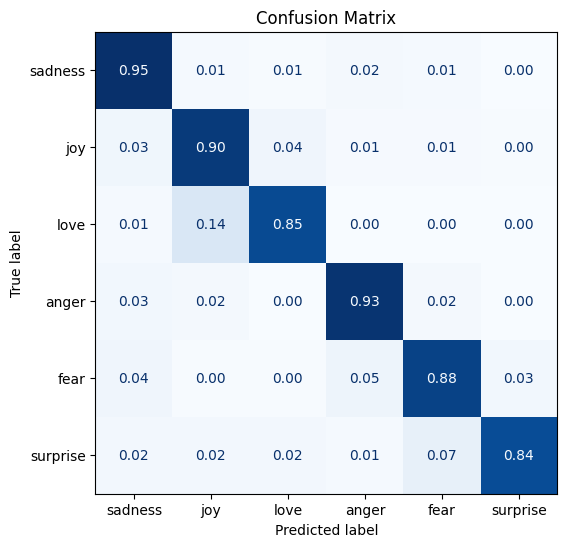

In [45]:
y_pred = np.argmax(pred_output.predictions, axis=-1)
y_valid = emotions_encoded["validation"]['label']
# plot the confusion matrix
plot_confusion_matrix(y_valid, y_pred, labels=list(id2label.keys()),normalize='true')

## Saving the model on Hub

In [23]:
# Push the model on hugging face hub
trainer.push_to_hub(commit_message="Training completed!")

CommitInfo(commit_url='https://huggingface.co/sfarrukh/distilbert-base-uncased-finetuned-emotion/commit/42ea70b2af2661e51577c9d82920d5ef9ffbb4b1', commit_message='Training completed!', commit_description='', oid='42ea70b2af2661e51577c9d82920d5ef9ffbb4b1', pr_url=None, pr_revision=None, pr_num=None)

In [6]:
# load the model from hub space
from transformers import pipeline
model_id="sfarrukh/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification",model=model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
emotions_encoded

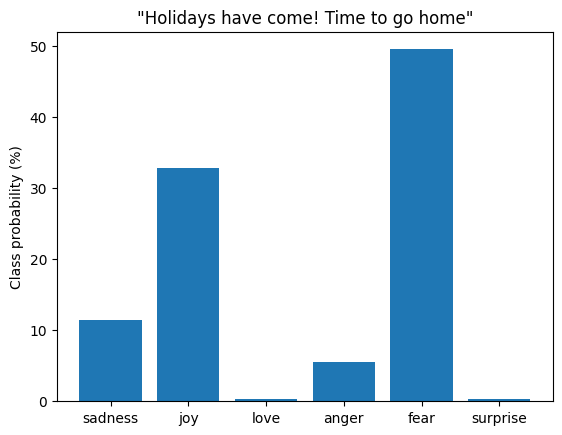

In [26]:
import pandas as pd
new_tweet="Holidays have come! Time to go home"
emotion_label = classifier(new_tweet,return_all_scores=True)
df=pd.DataFrame(emotion_label[0])
df['label']=id2label.values()
plt.bar(df['label'],df['score']*100)
plt.title(f'"{new_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

In [18]:
id2label

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [17]:
df['label'].map(id2label)


0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: label, dtype: object